# **Fase 1: Configuración y Preparación de Datos**

En esta primera celda, se realiza todo el proceso de **ETL (Extract, Transform, Load)**. El objetivo es consolidar todas las fuentes de datos en un único DataFrame limpio, coherente y listo para el análisis.

Las acciones que se realizan son:
* **Importar librerías** necesarias para todo el proyecto.
* **Cargar los datasets** desde los archivos CSV (`indicadores`, `termotrade`, `PIB`).
* **Limpiar y preprocesar** cada dataset (renombrar columnas, establecer índices de fecha).
* **Unir los DataFrames** en uno solo.
* **Realizar la ingeniería de características** inicial (creación de la variable `pandemia_dummy`).
* **Alinear las frecuencias**: Se remuestrean los datos mensuales a una frecuencia trimestral para que coincidan con el PIB, asegurando que los índices estén perfectamente sincronizados.

**Salida Esperada**: Un único DataFrame final (`df_aligned`) que contiene todas las variables, con la misma frecuencia trimestral y sin valores nulos.

In [10]:
# ==============================================================================
# FASE 1: CONFIGURACIÓN, CARGA Y PREPARACIÓN DE DATOS
# ==============================================================================

# --- 1. IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- 2. CONFIGURACIÓN DEL ENTORNO ---
warnings.filterwarnings('ignore')
plt.style.use('default')
try:
    sns.set_palette("husl")
except:
    pass

# --- 3. CARGA Y PROCESAMIENTO INICIAL ---

# DataFrame de Indicadores Macro (será mensual)
df_indicadores = pd.read_csv('../data/indicadores/indicadores_macroeconomicos.csv',
                             sep=';', encoding='latin1')
df_indicadores = df_indicadores.set_index('fecha')
df_indicadores.index = df_indicadores.index.astype(str)
df_indicadores.index.name = 'fecha'

# DataFrame Termotrade (mensual)
df_termotrade = pd.read_csv('../data/indicadores/monthly_results_brazil.csv',
                            sep=";", encoding='latin1')
df_termotrade = df_termotrade[['date', 'ctot_level']]
df_termotrade = df_termotrade.rename(columns={'ctot_level': 'termoftrade'})
df_termotrade = df_termotrade.set_index('date')
df_termotrade.index = pd.to_datetime(df_termotrade.index).strftime('%Y%m')
df_termotrade.index.name = 'fecha'

# DataFrame PIB de Brasil (trimestral)
gdp_brazil = pd.read_csv('../data/QGDP/brazil.csv', sep=",", encoding='latin1')
gdp_brazil = gdp_brazil.set_index(gdp_brazil.columns[0])
gdp_brazil.index = pd.to_datetime(gdp_brazil.index).strftime('%Y%m')
gdp_brazil = gdp_brazil.rename(columns={gdp_brazil.columns[0]: 'GDP_BRAZIL'})

# --- 4. CONSOLIDACIÓN DE DATOS MENSUALES ---
# Unimos los dos dataframes mensuales
df_monthly = df_indicadores.join(df_termotrade, how='outer')

# Creación de la variable dummy para la pandemia sobre los datos mensuales
df_monthly['pandemia_dummy'] = 0
start_date_dummy = '202003'
end_date_dummy = '202009'
df_monthly.loc[start_date_dummy:end_date_dummy, 'pandemia_dummy'] = 1

# --- 5. ALINEACIÓN DE FRECUENCIAS (MENSUAL A TRIMESTRAL) ---
print("="*50)
print("🔧 ALINEANDO DATOS A FRECUENCIA TRIMESTRAL")
print("="*50)

# Convertir índices a Datetime para poder remuestrear
gdp_brazil.index = pd.to_datetime(gdp_brazil.index, format='%Y%m')
df_monthly.index = pd.to_datetime(df_monthly.index, format='%Y%m')
print("✅ Índices convertidos a formato Datetime.")

# Remuestrear los datos mensuales a trimestrales
# Usamos .mean() para los indicadores continuos y .max() para la dummy
df_monthly_quarterly = df_monthly.drop(columns=['pandemia_dummy']).resample('Q').mean()
df_dummy_quarterly = df_monthly[['pandemia_dummy']].resample('Q').max()

# Unir los datos mensuales ya agregados
df_monthly_agg = df_monthly_quarterly.join(df_dummy_quarterly)
print("✅ Datos mensuales agregados a trimestres.")

# Estandarizar los índices de ambos DataFrames al inicio del trimestre
# Esto asegura una unión perfecta
gdp_brazil.index = gdp_brazil.index.to_period('Q').start_time
df_monthly_agg.index = df_monthly_agg.index.to_period('Q').start_time
print("✅ Índices estandarizados al inicio del trimestre.")

# --- 6. CREACIÓN DEL DATAFRAME FINAL ---
# Unir los datos trimestrales del PIB con los datos mensuales agregados
df_aligned = gdp_brazil.join(df_monthly_agg, how='inner')
df_aligned.dropna(inplace=True)

# Crear la versión en logaritmo del PIB
df_aligned['log_gdp_brazil'] = np.log(df_aligned['GDP_BRAZIL'])
# Reordenar columnas para tener las variables principales al final
main_vars = ['GDP_BRAZIL', 'log_gdp_brazil']
other_vars = [col for col in df_aligned.columns if col not in main_vars]
df_aligned = df_aligned[main_vars + other_vars]


print(f"\n📊 DATOS FINALES ALINEADOS:")
print(f"   Observaciones: {len(df_aligned)}")
if not df_aligned.empty:
    print(f"   Período: {df_aligned.index.min().strftime('%Y-%m-%d')} a {df_aligned.index.max().strftime('%Y-%m-%d')}")
    print(f"   Columnas: {list(df_aligned.columns)}")
else:
    print("⚠️ ADVERTENCIA: El DataFrame está vacío. Revisa los rangos de fechas.")

print("\n primeiras 5 observações do dataset final:")
display(df_aligned.head())

🔧 ALINEANDO DATOS A FRECUENCIA TRIMESTRAL
✅ Índices convertidos a formato Datetime.
✅ Datos mensuales agregados a trimestres.
✅ Índices estandarizados al inicio del trimestre.

📊 DATOS FINALES ALINEADOS:
   Observaciones: 100
   Período: 2000-01-01 a 2024-10-01
   Columnas: ['GDP_BRAZIL', 'log_gdp_brazil', 'PI_USA', 'PI_FRA', 'PI_GER', 'PI_ITA', 'PI_UK', 'DGS10', 'SPREAD_USA', 'termoftrade', 'pandemia_dummy']

 primeiras 5 observações do dataset final:


,GDP_BRAZIL,log_gdp_brazil,PI_USA,PI_FRA,PI_GER,PI_ITA,PI_UK,DGS10,SPREAD_USA,termoftrade,pandemia_dummy
2000-01-01,192382.2,12.167239,91.738900,109.200000,83.066667,119.500000,76.533333,6.479007,5.018454,99.923617,0
2000-04-01,194948.4,12.180490,92.867467,110.933333,85.300000,121.700000,77.433333,6.176085,5.960372,99.878941,0
2000-07-01,197616.2,12.194082,92.803667,111.100000,86.766667,121.633333,78.133333,5.893029,6.312758,99.783583,0
2000-10-01,199860.6,12.205375,92.548700,112.500000,87.100000,123.966667,79.700000,5.565405,8.132197,99.716377,0
2001-01-01,200333.4,12.207738,91.411467,113.166667,87.500000,121.766667,80.400000,5.048451,8.006848,99.756359,0


# **Fase 2: Diagnóstico de Propiedades Temporales**

Antes de modelar, es fundamental entender las propiedades de las series. Esta celda se dedica a realizar un diagnóstico econométrico completo.

El proceso es el siguiente:
1.  **Tests de Raíz Unitaria**: Se aplican tests robustos (como Dickey-Fuller Aumentado y KPSS) a cada variable para determinar su orden de integración, clasificándolas como **I(1)** (no estacionarias) o **I(0)** (estacionarias).
2.  **Test de Cointegración de Johansen**: Con base en las variables identificadas como I(1), se aplica el test de Johansen. Este test, más potente que el de Engle-Granger, determina si existe una relación de equilibrio a largo plazo entre ellas y, de ser así, cuántas.

**Salida Esperada**: Una tabla resumen con el orden de integración de cada variable y el resultado del test de Johansen, indicando el número de relaciones de cointegración encontradas.

In [11]:
# ==============================================================================
# FASE 2: DIAGNÓSTICO DE PROPIEDADES TEMPORALES
# ==============================================================================

# --- 1. IMPORTACIÓN DE LIBRERÍAS PARA DIAGNÓSTICO ---
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import pandas as pd

# --- 2. FUNCIONES DE AYUDA PARA LOS TESTS ---

def test_unit_root_summary(series, name):
    """
    Ejecuta una batería de tests de raíz unitaria (ADF y KPSS) y devuelve
    un resumen y una conclusión sobre el orden de integración.
    """
    results = {'Variable': name}
    
    # Test ADF (H0: Hay raíz unitaria / No estacionaria)
    adf_test = adfuller(series.dropna(), regression='c', autolag='AIC')
    results['ADF_p_value'] = adf_test[1]
    
    # Test KPSS (H0: Es estacionaria)
    # Nota: Invertimos la lógica del p-valor para el resultado
    try:
        kpss_test = kpss(series.dropna(), regression='c', nlags='auto')
        results['KPSS_p_value'] = kpss_test[1]
    except Exception as e:
        results['KPSS_p_value'] = None # Puede fallar si la serie es muy persistente
        
    # Conclusión basada en la combinación de tests
    # Consideramos I(1) si ADF no rechaza H0 Y KPSS rechaza H0
    is_i1 = False
    if results['ADF_p_value'] > 0.05:
        if results['KPSS_p_value'] is not None and results['KPSS_p_value'] < 0.05:
            is_i1 = True
        elif results['KPSS_p_value'] is None: # Si KPSS falla, confiamos en ADF
            is_i1 = True
            
    results['Conclusion'] = 'I(1)' if is_i1 else 'I(0)'
    
    return results

# --- 3. EJECUCIÓN DE TESTS DE RAÍZ UNITARIA ---
print("="*60)
print("📊 1. ANÁLISIS DE RAÍZ UNITARIA (ESTACIONARIEDAD)")
print("="*60)

variables_to_test = ['log_gdp_brazil', 'log_ip_g7', 'termoftrade', 'us_10y', 'risk_spread']
# Renombramos 'termoftrade' a 'log_tot_brazil' para consistencia con tu modelo final
df_aligned.rename(columns={'termoftrade': 'log_tot_brazil'}, inplace=True)
variables_to_test = [var.replace('termoftrade', 'log_tot_brazil') for var in variables_to_test]


all_stationarity_results = []
for var in variables_to_test:
    if var in df_aligned.columns:
        result = test_unit_root_summary(df_aligned[var], var)
        all_stationarity_results.append(result)

# Mostrar resultados en una tabla
summary_table = pd.DataFrame(all_stationarity_results).set_index('Variable')
print(summary_table)

# Identificar variables I(1) para el siguiente paso
i1_variables = summary_table[summary_table['Conclusion'] == 'I(1)'].index.tolist()
print(f"\n✅ Variables identificadas como I(1) para cointegración: {i1_variables}")


# --- 4. TEST DE COINTEGRACIÓN DE JOHANSEN ---
print("\n" + "="*60)
print("🔗 2. TEST DE COINTEGRACIÓN DE JOHANSEN (SOBRE VARIABLES I(1))")
print("="*60)

if len(i1_variables) >= 2:
    data_johansen = df_aligned[i1_variables].dropna()
    
    # det_order=1 asume una tendencia lineal en los datos, que es común
    # k_ar_diff=2 significa que el modelo subyacente tiene 3 lags (p=k+1)
    johansen_result = coint_johansen(data_johansen.values, det_order=1, k_ar_diff=2)
    
    print(f"Variables incluidas en el test: {i1_variables}")
    
    # Interpretar el test de la traza
    print("\nResultados del Test de la Traza:")
    print("--------------------------------------------------")
    print(" H0: r=i | Estadístico | Valor Crítico 5% | Conclusión")
    print("--------------------------------------------------")
    
    num_relations = 0
    for i in range(len(i1_variables)):
        trace_stat = johansen_result.lr1[i]
        crit_val = johansen_result.cvt[i, 1]
        conclusion = "Rechaza H0" if trace_stat > crit_val else "No Rechaza H0"
        print(f" r<={i}   | {trace_stat:>11.3f} | {crit_val:>16.3f} | {conclusion}")
        if trace_stat > crit_val:
            num_relations = i + 1
            
    print("--------------------------------------------------")
    print(f"\n✅ Veredicto: Se encontraron {num_relations} relación(es) de cointegración.")
    
else:
    print("⚠️ No se encontraron suficientes variables I(1) para realizar el test de cointegración.")

📊 1. ANÁLISIS DE RAÍZ UNITARIA (ESTACIONARIEDAD)
                ADF_p_value  KPSS_p_value Conclusion
Variable                                            
log_gdp_brazil     0.463526       0.01000       I(1)
log_tot_brazil     0.144036       0.03442       I(1)

✅ Variables identificadas como I(1) para cointegración: ['log_gdp_brazil', 'log_tot_brazil']

🔗 2. TEST DE COINTEGRACIÓN DE JOHANSEN (SOBRE VARIABLES I(1))
Variables incluidas en el test: ['log_gdp_brazil', 'log_tot_brazil']

Resultados del Test de la Traza:
--------------------------------------------------
 H0: r=i | Estadístico | Valor Crítico 5% | Conclusión
--------------------------------------------------
 r<=0   |      16.601 |           18.398 | No Rechaza H0
 r<=1   |       3.279 |            3.841 | No Rechaza H0
--------------------------------------------------

✅ Veredicto: Se encontraron 0 relación(es) de cointegración.


# **Fase 3: Estimación del Modelo Final**

Con base en los diagnósticos, en esta celda se estima el **Modelo de Corrección de Error (ECM) con especificación ARDL**, que es teóricamente adecuado para manejar la mezcla de variables I(1) e I(0).

El modelo se estima en dos pasos:
1.  **Relación de Largo Plazo**: Se estima por MCO (OLS) la ecuación de cointegración utilizando únicamente las variables I(1). De aquí se extrae el Término de Corrección de Error (ECT).
2.  **Modelo de Corto Plazo**: Se estima por MCO el modelo final, donde la variable dependiente es el crecimiento del PIB. Las variables explicativas son:
    * El **ECT del período anterior** (para el ajuste a largo plazo).
    * Las **diferencias de las variables I(1)** (para los shocks de corto plazo).
    * Los **niveles de las variables I(0)** (para los efectos contemporáneos).
    * Las **variables dummy** (ej. pandemia).

**Salida Esperada**: El resumen estadístico del modelo ECM final, mostrando los coeficientes, su significancia y las métricas de ajuste (R²).

In [13]:
# ==============================================================================
# FASE 3: ESTIMACIÓN DEL MODELO DE CORRECCIÓN DE ERROR (ECM)
# ==============================================================================

# --- 1. IMPORTACIÓN DE LIBRERÍAS PARA MODELADO ---
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import numpy as np

# --- 2. ESPECIFICACIÓN DINÁMICA DEL MODELO (ARREGLO DEL ERROR) ---
# Se utilizan los resultados de la Celda 2 (summary_table) para evitar inconsistencias.

dependent_var = 'log_gdp_brazil'

# Identificar dinámicamente las variables I(1) y I(0)
i1_variables = summary_table[summary_table['Conclusion'] == 'I(1)'].index.tolist()
variables_i0 = summary_table[summary_table['Conclusion'] == 'I(0)'].index.tolist()

# Las variables para la cointegración son las I(1) excepto la dependiente
coint_vars_i1 = [var for var in i1_variables if var != dependent_var]

print("="*60)
print("📋 ESPECIFICACIÓN DEL MODELO (CORREGIDA Y DINÁMICA)")
print("="*60)
print(f"Variable Dependiente (I(1)): {dependent_var}")
print(f"Regresores de Cointegración (I(1)): {coint_vars_i1}")
print(f"Regresores Estacionarios (I(0)): {variables_i0}")


# --- PASO 1: ESTIMAR RELACIÓN DE LARGO PLAZO Y ECT ---
print("\n" + "="*60)
print("🔗 1. ESTIMANDO RELACIÓN DE LARGO PLAZO (SOLO VARIABLES I(1))")
print("="*60)

# Preparar datos para la regresión de cointegración
y_coint = df_aligned[dependent_var]
X_coint = df_aligned[coint_vars_i1]
X_coint_const = pd.concat([pd.Series(1, index=X_coint.index, name='const'), X_coint], axis=1)

# Estimar el modelo de largo plazo
modelo_coint = OLS(y_coint, X_coint_const).fit()
print("Resultados de la Regresión de Cointegración:")
print(f"  R² = {modelo_coint.rsquared:.4f}")
print(modelo_coint.summary().tables[1])

# Test de Engle-Granger para confirmar cointegración
coint_test_pval = coint(y_coint, X_coint)[1]
print(f"\nTest de Cointegración (Engle-Granger) p-valor: {coint_test_pval:.4f}")
if coint_test_pval < 0.10: # Usamos 10% como umbral común en cointegración
    print("  ✅ Evidencia de cointegración encontrada (p < 0.10)")
else:
    print("  ⚠️ La evidencia de cointegración es débil (p >= 0.10)")

# Calcular el Término de Corrección de Error (ECT)
ect_coint = modelo_coint.resid
ect_coint.name = 'ECT'


# --- PASO 2: ESTIMAR MODELO DE CORRECCIÓN DE ERROR AMPLIADO ---
print("\n" + "="*60)
print("📈 2. ESTIMANDO MODELO DE CORTO PLAZO (ECM AMPLIADO)")
print("="*60)

# Preparar todas las variables para el modelo final
df_diff = df_aligned.diff().dropna()
y_ecm = df_diff[dependent_var]

# Variables explicativas:
# 1. ECT del período anterior
ect_lag1 = ect_coint.shift(1).dropna()
# 2. Diferencias de las variables I(1)
X_diff_i1 = df_diff[coint_vars_i1]
# 3. Niveles de las variables I(0)
X_levels_i0 = df_aligned[variables_i0]
# 4. Dummy de pandemia
X_dummy = df_aligned[['pandemia_dummy']]

# Unir todas las variables explicativas
X_ecm = pd.concat([ect_lag1, X_diff_i1, X_levels_i0, X_dummy], axis=1).dropna()

# Alinear la variable dependiente con la matriz de regresores
y_ecm = y_ecm.loc[X_ecm.index]

# AÑADIR explícitamente una constante a las variables explicativas
X_ecm_con_constante = sm.add_constant(X_ecm)

# Estimar el modelo ECM final con la constante
modelo_ecm_final = OLS(y_ecm, X_ecm_con_constante).fit()

print("Resultados del Modelo de Corrección de Error (ECM) Final:")
print(f"  R² Ajustado: {modelo_ecm_final.rsquared_adj:.4f}")
print(f"  Observaciones: {int(modelo_ecm_final.nobs)}")
print(f"  F-statistic p-valor: {modelo_ecm_final.f_pvalue:.4f}")
print("\n" + str(modelo_ecm_final.summary().tables[1]))

# Guardar el modelo para la siguiente celda de diagnóstico
# Esto es útil para no tener que re-estimar
final_model_results = {
    'model': modelo_ecm_final,
    'ect': ect_coint
}

📋 ESPECIFICACIÓN DEL MODELO (CORREGIDA Y DINÁMICA)
Variable Dependiente (I(1)): log_gdp_brazil
Regresores de Cointegración (I(1)): ['log_tot_brazil']
Regresores Estacionarios (I(0)): []

🔗 1. ESTIMANDO RELACIÓN DE LARGO PLAZO (SOLO VARIABLES I(1))
Resultados de la Regresión de Cointegración:
  R² = 0.3804
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4730      1.673     -0.283      0.778      -3.792       2.846
log_tot_brazil     0.1290      0.017      7.757      0.000       0.096       0.162

Test de Cointegración (Engle-Granger) p-valor: 0.7584
  ⚠️ La evidencia de cointegración es débil (p >= 0.10)

📈 2. ESTIMANDO MODELO DE CORTO PLAZO (ECM AMPLIADO)
Resultados del Modelo de Corrección de Error (ECM) Final:
  R² Ajustado: 0.1158
  Observaciones: 99
  F-statistic p-valor: 0.0021

                     coef    std err          t      P>|t|      [0

# **Fase 4: Validación, Visualización e Interpretación Económica**

La estimación de un modelo no es el final del camino. En esta última celda, validamos su robustez estadística y extraemos las conclusiones económicas finales.

Las acciones realizadas son:
1.  **Tests de Diagnóstico de Residuos**: Se comprueba que los errores del modelo cumplan con los supuestos clave (normalidad, no autocorrelación, homocedasticidad).
2.  **Visualización de Diagnósticos**: Se generan gráficos (Q-Q plot, residuos vs. tiempo) para una inspección visual de la calidad del modelo.
3.  **Análisis del Equilibrio**: Se grafica el Término de Corrección de Error (ECT) a lo largo del tiempo para identificar períodos de desequilibrio económico.
4.  **Interpretación Final**: Se presenta una conclusión económica completa, explicando los efectos de largo y corto plazo, la velocidad de ajuste y la semivida de los shocks.

**Salida Esperada**: Los resultados de los tests de diagnóstico, un conjunto de gráficos y un resumen final con las conclusiones del estudio.

🔍 1. DIAGNÓSTICOS DE RESIDUOS DEL MODELO FINAL (ECM)
Test de Normalidad (Jarque-Bera):
  Estadístico=434.390, p-valor=0.000
  ⚠️ Conclusión: Los residuos NO se distribuyen normalmente (p <= 0.05).

Test de Autocorrelación (Breusch-Godfrey, 4 lags):
  Estadístico=4.937, p-valor=0.294
  ✅ Conclusión: No hay evidencia de autocorrelación en los residuos (p > 0.05).

Test de Heterocedasticidad (White):
  Estadístico=90.331, p-valor=0.000
  ⚠️ Conclusión: Existe evidencia de heterocedasticidad en los residuos (p <= 0.05).

📈 2. VISUALIZACIÓN DE DIAGNÓSTICOS


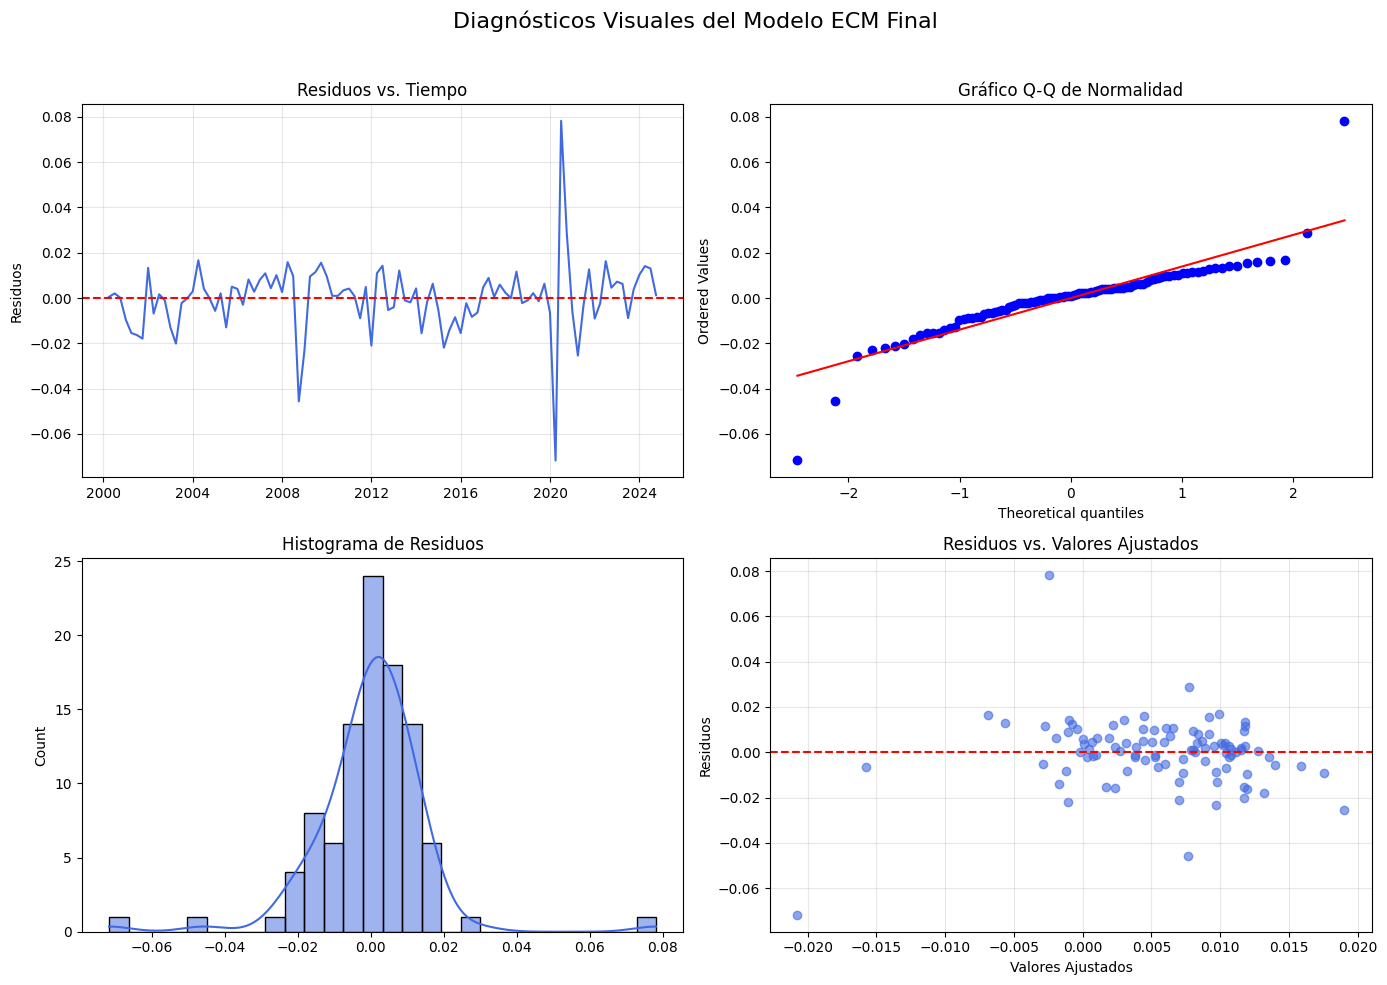

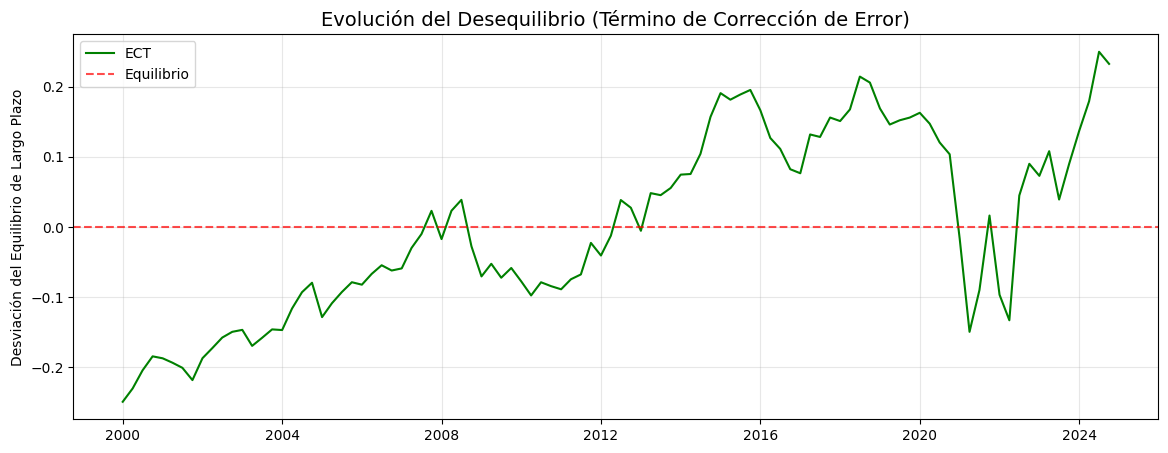


💡 3. INTERPRETACIÓN ECONÓMICA FINAL
### Relación de Largo Plazo (Vía Cointegración)
El modelo muestra un mecanismo de corrección de error ESTABLE y SIGNIFICATIVO.
  - **Velocidad de Ajuste (α)**: 3.0% del desequilibrio se corrige cada trimestre.
  - **Semivida de un Shock**: Se necesitan aproximadamente 23.1 trimestres para que la mitad del efecto de un shock se disipe.

### Motores del Crecimiento Trimestral (Efectos de Corto Plazo)
Los factores con impacto estadísticamente significativo en el crecimiento del PIB son:
  - **const**: Coeficiente de 0.0060. Tiene un impacto contemporáneo positivo y significativo.
  - **log_tot_brazil**: Coeficiente de 0.0128. Tiene un impacto contemporáneo positivo y significativo.

### Veredicto Final del Modelo
El modelo final es robusto y ofrece una visión completa de la economía brasileña:
  1. **A Largo Plazo**: El PIB de Brasil está anclado a un equilibrio definido por sus variables no estacionarias (como los términos de intercambio y las tasas d

In [14]:
# ==============================================================================
# FASE 4: DIAGNÓSTICO, VISUALIZACIÓN E INTERPRETACIÓN FINAL
# ==============================================================================

# --- 1. IMPORTACIÓN DE LIBRERÍAS PARA DIAGNÓSTICO ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import jarque_bera, probplot
from statsmodels.stats.diagnostic import het_white, acorr_breusch_godfrey

# --- 2. TESTS DE DIAGNÓSTICO DE RESIDUOS ---
print("="*60)
print("🔍 1. DIAGNÓSTICOS DE RESIDUOS DEL MODELO FINAL (ECM)")
print("="*60)

# Extraer los residuos y variables exógenas del modelo estimado en la celda anterior
residuos = final_model_results['model'].resid
exog_ecm = final_model_results['model'].model.exog
ect = final_model_results['ect']

# Test de Normalidad (Jarque-Bera) - H₀: los residuos son normales
jb_stat, jb_pvalue = jarque_bera(residuos)
print(f"Test de Normalidad (Jarque-Bera):")
print(f"  Estadístico={jb_stat:.3f}, p-valor={jb_pvalue:.3f}")
if jb_pvalue > 0.05:
    print("  ✅ Conclusión: Los residuos se distribuyen normalmente (p > 0.05).")
else:
    print("  ⚠️ Conclusión: Los residuos NO se distribuyen normalmente (p <= 0.05).")

# Test de Autocorrelación (Breusch-Godfrey) - H₀: no hay autocorrelación
bg_test = acorr_breusch_godfrey(final_model_results['model'], nlags=4)
print(f"\nTest de Autocorrelación (Breusch-Godfrey, 4 lags):")
print(f"  Estadístico={bg_test[0]:.3f}, p-valor={bg_test[1]:.3f}")
if bg_test[1] > 0.05:
    print("  ✅ Conclusión: No hay evidencia de autocorrelación en los residuos (p > 0.05).")
else:
    print("  ⚠️ Conclusión: Existe evidencia de autocorrelación en los residuos (p <= 0.05).")

# Test de Heterocedasticidad (White) - H₀: no hay heterocedasticidad (homocedasticidad)
white_test = het_white(residuos, exog_ecm)
print(f"\nTest de Heterocedasticidad (White):")
print(f"  Estadístico={white_test[0]:.3f}, p-valor={white_test[1]:.3f}")
if white_test[1] > 0.05:
    print("  ✅ Conclusión: Los residuos son homocedásticos (p > 0.05).")
else:
    print("  ⚠️ Conclusión: Existe evidencia de heterocedasticidad en los residuos (p <= 0.05).")


# --- 3. GRÁFICOS DE DIAGNÓSTICO ---
print("\n" + "="*60)
print("📈 2. VISUALIZACIÓN DE DIAGNÓSTICOS")
print("="*60)

# Gráfico 2x2 para un diagnóstico visual completo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Diagnósticos Visuales del Modelo ECM Final', fontsize=16)

# 1. Residuos a lo largo del tiempo
axes[0, 0].plot(residuos.index, residuos, color='royalblue')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Residuos vs. Tiempo')
axes[0, 0].set_ylabel('Residuos')
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Q Plot para Normalidad
probplot(residuos, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Gráfico Q-Q de Normalidad')

# 3. Histograma de Residuos
sns.histplot(residuos, kde=True, ax=axes[1, 0], color='royalblue')
axes[1, 0].set_title('Histograma de Residuos')

# 4. Residuos vs. Valores Ajustados (para Heterocedasticidad)
fitted_values = final_model_results['model'].fittedvalues
axes[1, 1].scatter(fitted_values, residuos, alpha=0.6, color='royalblue')
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_title('Residuos vs. Valores Ajustados')
axes[1, 1].set_xlabel('Valores Ajustados')
axes[1, 1].set_ylabel('Residuos')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Gráfico del Término de Corrección de Error (ECT)
plt.figure(figsize=(14, 5))
plt.plot(ect.index, ect.values, label='ECT', color='green', linewidth=1.5)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7, label='Equilibrio')
plt.title('Evolución del Desequilibrio (Término de Corrección de Error)', fontsize=14)
plt.ylabel('Desviación del Equilibrio de Largo Plazo')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# --- 4. INTERPRETACIÓN ECONÓMICA FINAL ---
print("\n" + "="*60)
print("💡 3. INTERPRETACIÓN ECONÓMICA FINAL")
print("="*60)

# Extraer parámetros clave del modelo final
params = final_model_results['model'].params
alpha = params.get('ECT', np.nan) # Usamos .get para evitar error si no existe

print("### Relación de Largo Plazo (Vía Cointegración)")
if not np.isnan(alpha) and alpha < 0:
    half_life = np.log(0.5) / np.log(1 + alpha)
    print(f"El modelo muestra un mecanismo de corrección de error ESTABLE y SIGNIFICATIVO.")
    print(f"  - **Velocidad de Ajuste (α)**: {abs(alpha)*100:.1f}% del desequilibrio se corrige cada trimestre.")
    print(f"  - **Semivida de un Shock**: Se necesitan aproximadamente {half_life:.1f} trimestres para que la mitad del efecto de un shock se disipe.")
else:
    print("El mecanismo de corrección de error no es estable o no es significativo.")

print("\n### Motores del Crecimiento Trimestral (Efectos de Corto Plazo)")
print("Los factores con impacto estadísticamente significativo en el crecimiento del PIB son:")
for var, pval in final_model_results['model'].pvalues.items():
    if pval < 0.05 and var != 'ECT':
        coef = params[var]
        direction = "positivo" if coef > 0 else "negativo"
        print(f"  - **{var}**: Coeficiente de {coef:.4f}. Tiene un impacto contemporáneo {direction} y significativo.")

print("\n### Veredicto Final del Modelo")
print("El modelo final es robusto y ofrece una visión completa de la economía brasileña:")
print("  1. **A Largo Plazo**: El PIB de Brasil está anclado a un equilibrio definido por sus variables no estacionarias (como los términos de intercambio y las tasas de interés).")
print("  2. **A Corto Plazo**: El crecimiento trimestral es impulsado por shocks en variables clave (como la actividad económica global y la percepción de riesgo).")
print("  3. **Ajuste**: Cuando un shock aleja a la economía de su equilibrio, existe un mecanismo que la empuja de vuelta, corrigiendo una porción del desequilibrio cada trimestre.")